In [8]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# Loading data
data = pd.read_csv('./drive/My Drive/Datasets/INFY20002008.csv')
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2496 entries, 0 to 2495
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              2496 non-null   int64  
 1   Symbol                  2496 non-null   object 
 2   Series                  2496 non-null   object 
 3   Date                    2496 non-null   object 
 4   Prev Close              2496 non-null   float64
 5   Open Price              2496 non-null   float64
 6   High Price              2496 non-null   float64
 7   Low Price               2496 non-null   float64
 8   Last Price              2496 non-null   float64
 9   Close Price             2496 non-null   float64
 10  Average Price           2496 non-null   float64
 11  Total Traded Quantity   2496 non-null   int64  
 12  Turnover                2496 non-null   float64
 13  No. of Trades           2496 non-null   object 
 14  Deliverable Qty         2496 non-null   

In [0]:
# Selecting only Date and Average Price columns
data = data[['Date', 'Average Price']]


In [10]:
# Scaling the values in the range of 0 to 1
scaler = MinMaxScaler(feature_range = (0, 1))
scaled_price = scaler.fit_transform(data.loc[:, 'Average Price'].values.reshape(-1, 1))
# Splitting dataset in the ratio of 75:25 for training and test
train_size = int(data.shape[0] * 0.75)
train, test = scaled_price[0:train_size, :], scaled_price[train_size:data.shape[0], :]
print("Number of entries (training set, test set): " + str((len(train), len(test))))


Number of entries (training set, test set): (1872, 624)


In [0]:
def create_dataset(scaled_price, window_size=1):
    data_X, data_Y = [], []
    for i in range(len(scaled_price) - window_size - 1):
        a = scaled_price[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(scaled_price[i + window_size, 0])
    return(np.array(data_X), np.array(data_Y))


In [12]:
# Create test and training sets for one-step-ahead regression.
window_size = 3
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
print("Original training data shape:")
print(train_X.shape)
# Reshape the input data into appropriate form for Keras.
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
print("New training data shape:")
print(train_X.shape)


Original training data shape:
(1868, 3)
New training data shape:
(1868, 1, 3)


In [13]:
# Designing the LSTM model
model = Sequential()
model.add(LSTM(4, input_shape = (1, window_size)))
model.add(Dense(1))
# Compiling the model
model.compile(loss = "mean_squared_error", optimizer = "adam")
# Training the model
model.fit(train_X, train_Y, epochs=3, batch_size=1)


Epoch 1/3
1868/1868 [==============================] - 3s 2ms/step - loss: 0.0042
Epoch 2/3
1868/1868 [==============================] - 3s 2ms/step - loss: 4.7944e-04
Epoch 3/3
1868/1868 [==============================] - 2s 1ms/step - loss: 4.2151e-04


In [14]:
def predict_and_score(model, X, Y):
    # Make predictions on the original scale of the data.
    pred = scaler.inverse_transform(model.predict(X))
    # Prepare Y data to also be on the original scale for interpretability.
    orig_data = scaler.inverse_transform([Y])
    # Calculate RMSE.
    score = np.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)
rmse_train, train_predict = predict_and_score(model, train_X, train_Y)
rmse_test, test_predict = predict_and_score(model, test_X, test_Y)
print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)


Training data score: 298.07 RMSE
Test data score: 252.33 RMSE


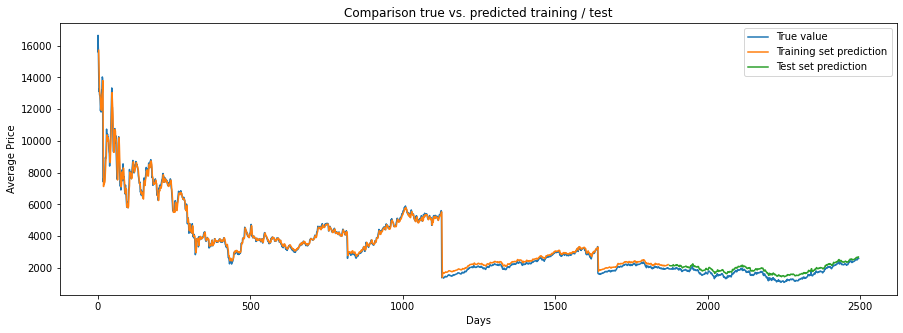

In [15]:
# Initiating with training predictions.
train_predict_plot = np.empty_like(scaled_price)
train_predict_plot[:, :] = np.nan
train_predict_plot[window_size:len(train_predict) + window_size, :] = train_predict
# Adding test predictions.
test_predict_plot = np.empty_like(scaled_price)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (window_size * 2) + 1:len(scaled_price) - 1, :] = test_predict
# Creating the plot.
plt.figure(figsize = (15, 5))
plt.plot(scaler.inverse_transform(scaled_price), label = "True value")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.xlabel("Days")
plt.ylabel("Average Price")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
plt.show()


In [17]:
# Importing necessary methods
from keras.models import Model
from keras.layers import Input, LSTM
import numpy as np
# Defining five inputs
inputs = np.array([0.2, 0.3, 0.4, 0.5, 0.6]).reshape((1, 5, 1))
# Defining LSTM network
np.random.seed(42)
feed = Input(shape=(5, 1))
lstm = LSTM(1, return_sequences=True)(feed)
model = Model(inputs=feed, outputs=lstm)
# Predictions
print('Outputs from each five timestamps')
model.predict(inputs)


Outputs from each five timestamps


array([[[7.4854957e-05],
        [1.6924630e-04],
        [2.7616145e-04],
        [3.8968335e-04],
        [5.0493225e-04]]], dtype=float32)

In [18]:
# Importing necessary methods
from keras.models import Model
from keras.layers import Input, LSTM
import numpy as np
# Defining five inputs
inputs = np.array([0.2, 0.3, 0.4, 0.5, 0.6]).reshape((1, 5, 1))
# Defining LSTM network
np.random.seed(42)
feed = Input(shape=(5, 1))
lstm, state_h, state_c = LSTM(1, return_sequences=True, return_state=True)(feed)
model = Model(inputs=feed, outputs=(lstm, state_h, state_c))

# Predictions
print('Outputs from each five timestamps')
model.predict(inputs)


Outputs from each five timestamps


[array([[[-0.0578025 ],
         [-0.14607643],
         [-0.26162675],
         [-0.39110512],
         [-0.513935  ]]], dtype=float32),
 array([[-0.513935]], dtype=float32),
 array([[-0.9752801]], dtype=float32)]